In [5]:
from PIL import Image
import numpy as np
import math
import cv2
import skimage.measure
import os

In [6]:
# def find_neighbors(x, y, img):
#     left_candidates = []
#     right_candidates = []
#     top_candidates = []
#     bottom_candidates = []
#     for i in range(len(by_x)):
#         if by_x[i][0] <= x and by_x[i+1][0] >= x:
#             left_candidates.append((by_x[i][0], by_x[i][1]))
#         if by_x[i][0] >= x and by_x[i-1][0] <= x:
#             right_candidates.append((by_x[i][0], by_x[i][1]))
#     for i in range(len(by_y)):
#         if by_y[i][1] <= y and by_y[i+1][1] >= y:
#             top_candidates.append((by_y[i][0], by_y[i][1]))
#         if by_y[i][1] >= y and by_y[i-1][1] <= y:
#             bottom_candidates.append((by_y[i][0], by_y[i][1]))
    
#     left_candidates.sort(key = lambda a: abs(a[1] - y))
#     right_candidates.sort(key = lambda a: abs(a[1] - y))
#     top_candidates.sort(key = lambda a: abs(a[0] - x))
#     bottom_candidates.sort(key = lambda a: abs(a[0] - x))

#     neighbors = []
#     for n in [left_candidates, right_candidates, top_candidates, bottom_candidates]:
#         if len(n) == 0:
#             continue
#         n = n[0]
#         neighbors.append(Neighbor(n[0], n[1], img[n[1], n[0]]))
    
#     return neighbors

In [7]:
class Neighbor:
    def __init__(self):
        pass
    def __init__(self, x, y, value):
        self.x = x
        self.y = y
        self.value = value
    def set_location(self, x, y):
        self.x = x
        self.y = y
    def set_value(self, value):
        self.value = value
    
    def __str__(self):
        return f"({self.x}, {self.y}) = {self.value}"

def find_neighbors(x, y, img, max_rad):
    rad = 0
    neighbors = []
    while len(neighbors) < 3 and rad < max_rad:
        rad += 1
        for dx in range(-rad, rad+1):
            dy = rad
            if dx == 0 and dy == 0:
                continue
            if x+dx < 0 or x+dx >= img.shape[0] or y+dy < 0 or y+dy >= img.shape[1]:
                continue
            if img[x+dx, y+dy] != 0:
                n = Neighbor(x = x+dx, y = y+dy, value = img[x+dx, y+dy])
                neighbors.append(n)
        for dx in range(-rad, rad+1):
            dy = -rad
            if dx == 0 and dy == 0:
                continue
            if x+dx < 0 or x+dx >= img.shape[0] or y+dy < 0 or y+dy >= img.shape[1]:
                continue
            if img[x+dx, y+dy] != 0:
                n = Neighbor(x = x+dx, y = y+dy, value = img[x+dx, y+dy])
                neighbors.append(n)
        for dy in range(-rad+1, rad):
            dx = rad
            if dx == 0 and dy == 0:
                continue
            if x+dx < 0 or x+dx >= img.shape[0] or y+dy < 0 or y+dy >= img.shape[1]:
                continue
            if img[x+dx, y+dy] != 0:
                n = Neighbor(x = x+dx, y = y+dy, value = img[x+dx, y+dy])
                neighbors.append(n)
        for dy in range(-rad+1, rad):
            dx = -rad
            if dx == 0 and dy == 0:
                continue
            if x+dx < 0 or x+dx >= img.shape[0] or y+dy < 0 or y+dy >= img.shape[1]:
                continue
            if img[x+dx, y+dy] != 0:
                n = Neighbor(x = x+dx, y = y+dy, value = img[x+dx, y+dy])
                neighbors.append(n)

    return neighbors

def weighted_interpolation(x, y, neighbors):
    numerator = 0
    denominator = 0

    w = lambda d: math.exp(-0.5*d)
    d = lambda x1, y1, x2, y2: math.sqrt((x1-x2)**2 + (y1-y2)**2)

    for n in neighbors:
        distance = d(x, y, n.x, n.y)
        numerator += n.value * w(distance)
        denominator += w(distance)
    
    return numerator / denominator

def fill_pixel(x, y, img, max_rad = 30):
    if img[x, y] == 0:
      neighbors = find_neighbors(x, y, img, max_rad)
      
      # if (np.all([n.y >= y for n in neighbors])):
      #   return 255
      if len(neighbors) == 0:
          return 0
      return weighted_interpolation(x, y, neighbors)
    else:
      return img[x, y]
    
def imresize(im, size, interp='nearest'):
    if interp == 'nearest':
        resample = Image.NEAREST
    elif interp == 'bilinear':
        resample = Image.BILINEAR
    elif interp == 'bicubic':
        resample = Image.BICUBIC
    else:
        raise Exception('resample method undefined!')

    return im.resize(size, resample)

def lin_mapping(vector, max_val = 250):
    distance_scaled = np.interp(vector, [0, max_val], [0, 255]).astype(np.uint8)
    return distance_scaled

def log_mapping(vector, max_val = 250):
    log1p = lambda x: 255 * math.log(x + 1) / math.log(max_val + 1)
    distance_scaled = np.vectorize(log1p)(vector).astype(np.uint8)
    return distance_scaled
    
def densify(img):
    a = skimage.measure.block_reduce(img, (12, 12), np.max)
    new_img = np.zeros(a.shape, dtype=np.int8)

    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            new_img[i, j] = fill_pixel(i, j, a, max_rad = 3)

    interp = Image.fromarray(new_img, mode="L")
    return imresize(interp, (1920, 1080))

In [8]:
root_dir = f"/Data/dataLIDAR/0221-1817_seed_9876/clear_night"

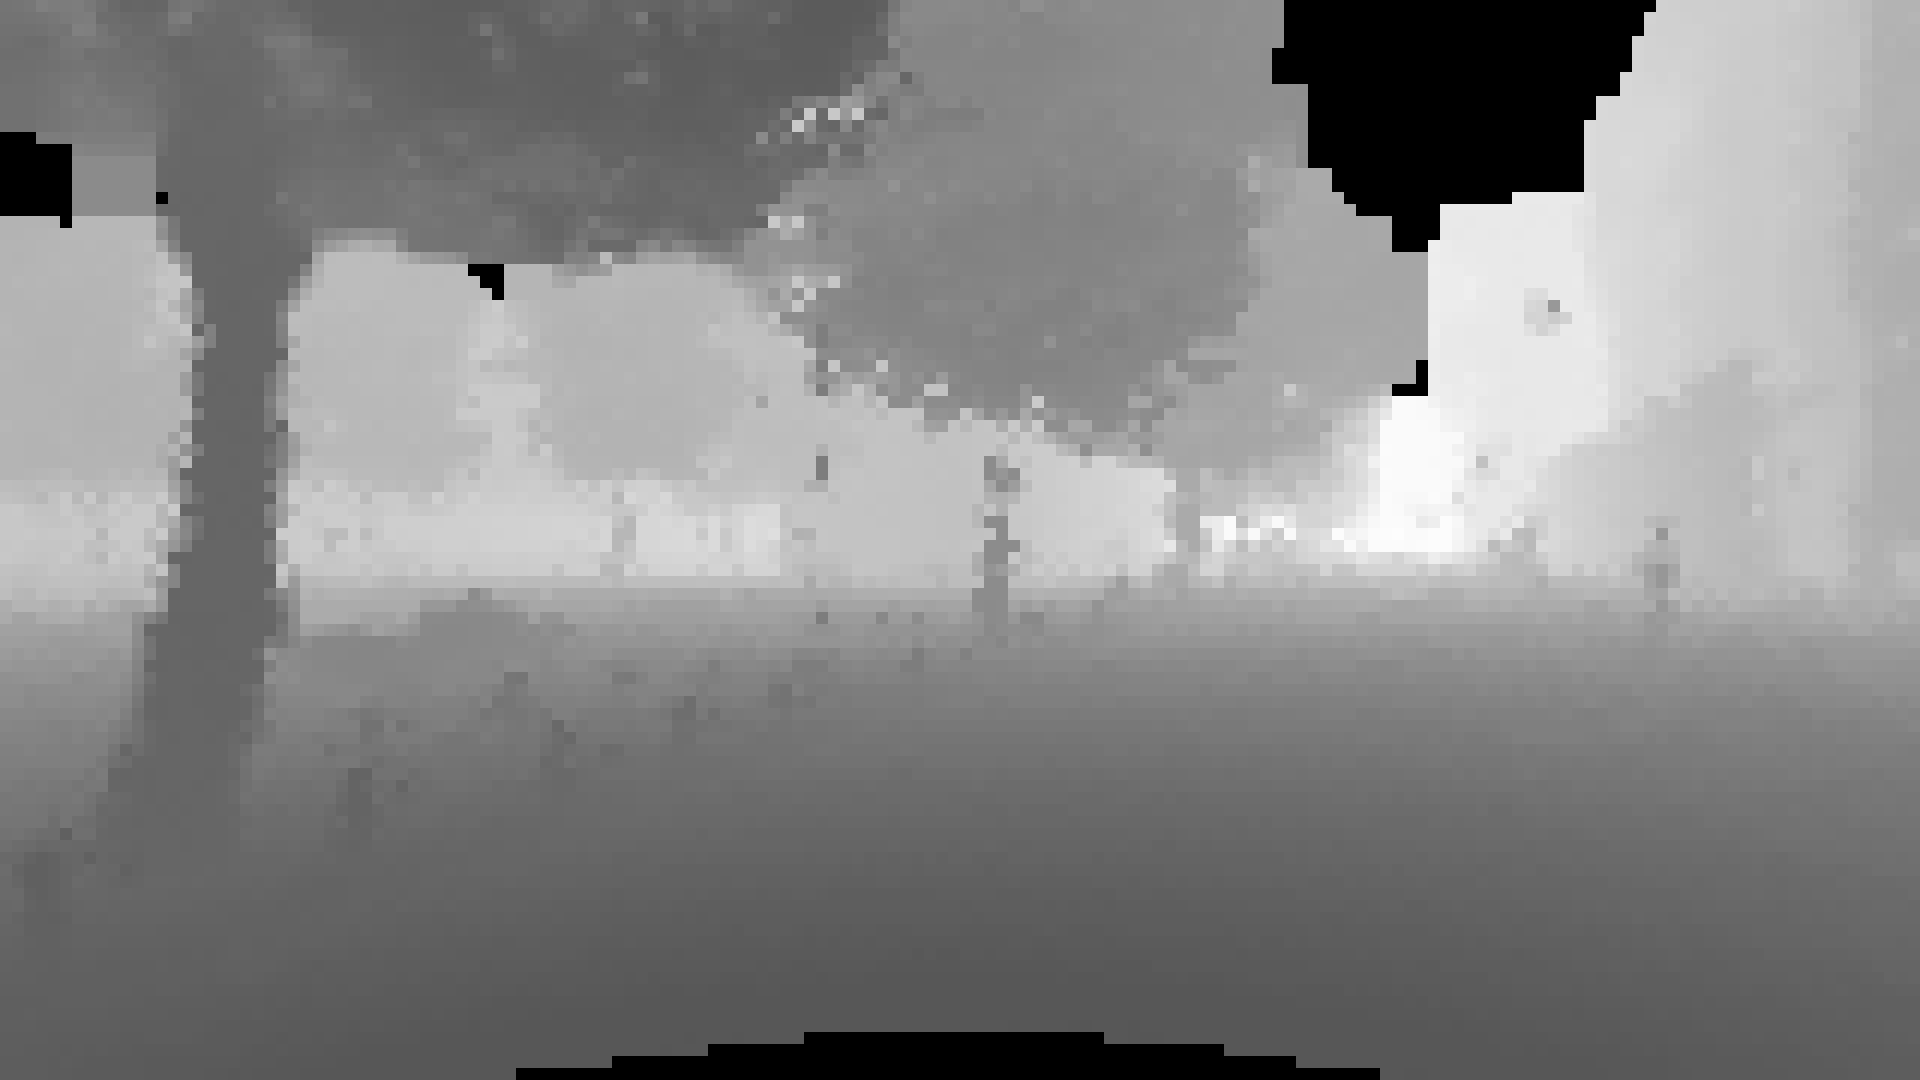

In [9]:
def to_sparse_depth_image(lidar, w, h):
    VCOORD = 0
    UCOORD = 1
    DISTANCE = 3

    vcoord = lidar[VCOORD].astype(np.uint16)
    ucoord = lidar[UCOORD].astype(np.uint16)

    # distance_cm = (lidar[DISTANCE] * 100).astype(np.uint16)
    distance_scaled = log_mapping(lidar[DISTANCE], 250)
    # distance_scaled = np.interp(lidar[DISTANCE], [0, 250], [0, 255]).astype(np.uint8)

    distance = np.zeros((h, w), dtype=np.uint8)
    distance[vcoord, ucoord] = distance_scaled

    return distance

def test(lidar, rgb, root_dir):
    rgb_arr = np.array(Image.open(os.path.join(root_dir, 'rgb', rgb)).convert('RGB'), dtype = np.uint8)
    lidar_arr = np.load(os.path.join(root_dir, 'lidar_2d', lidar))
    distance = to_sparse_depth_image(lidar_arr, rgb_arr.shape[1], rgb_arr.shape[0])
    distance = densify(distance)
    return distance

result = test('11.npy', '11.png', root_dir)
result

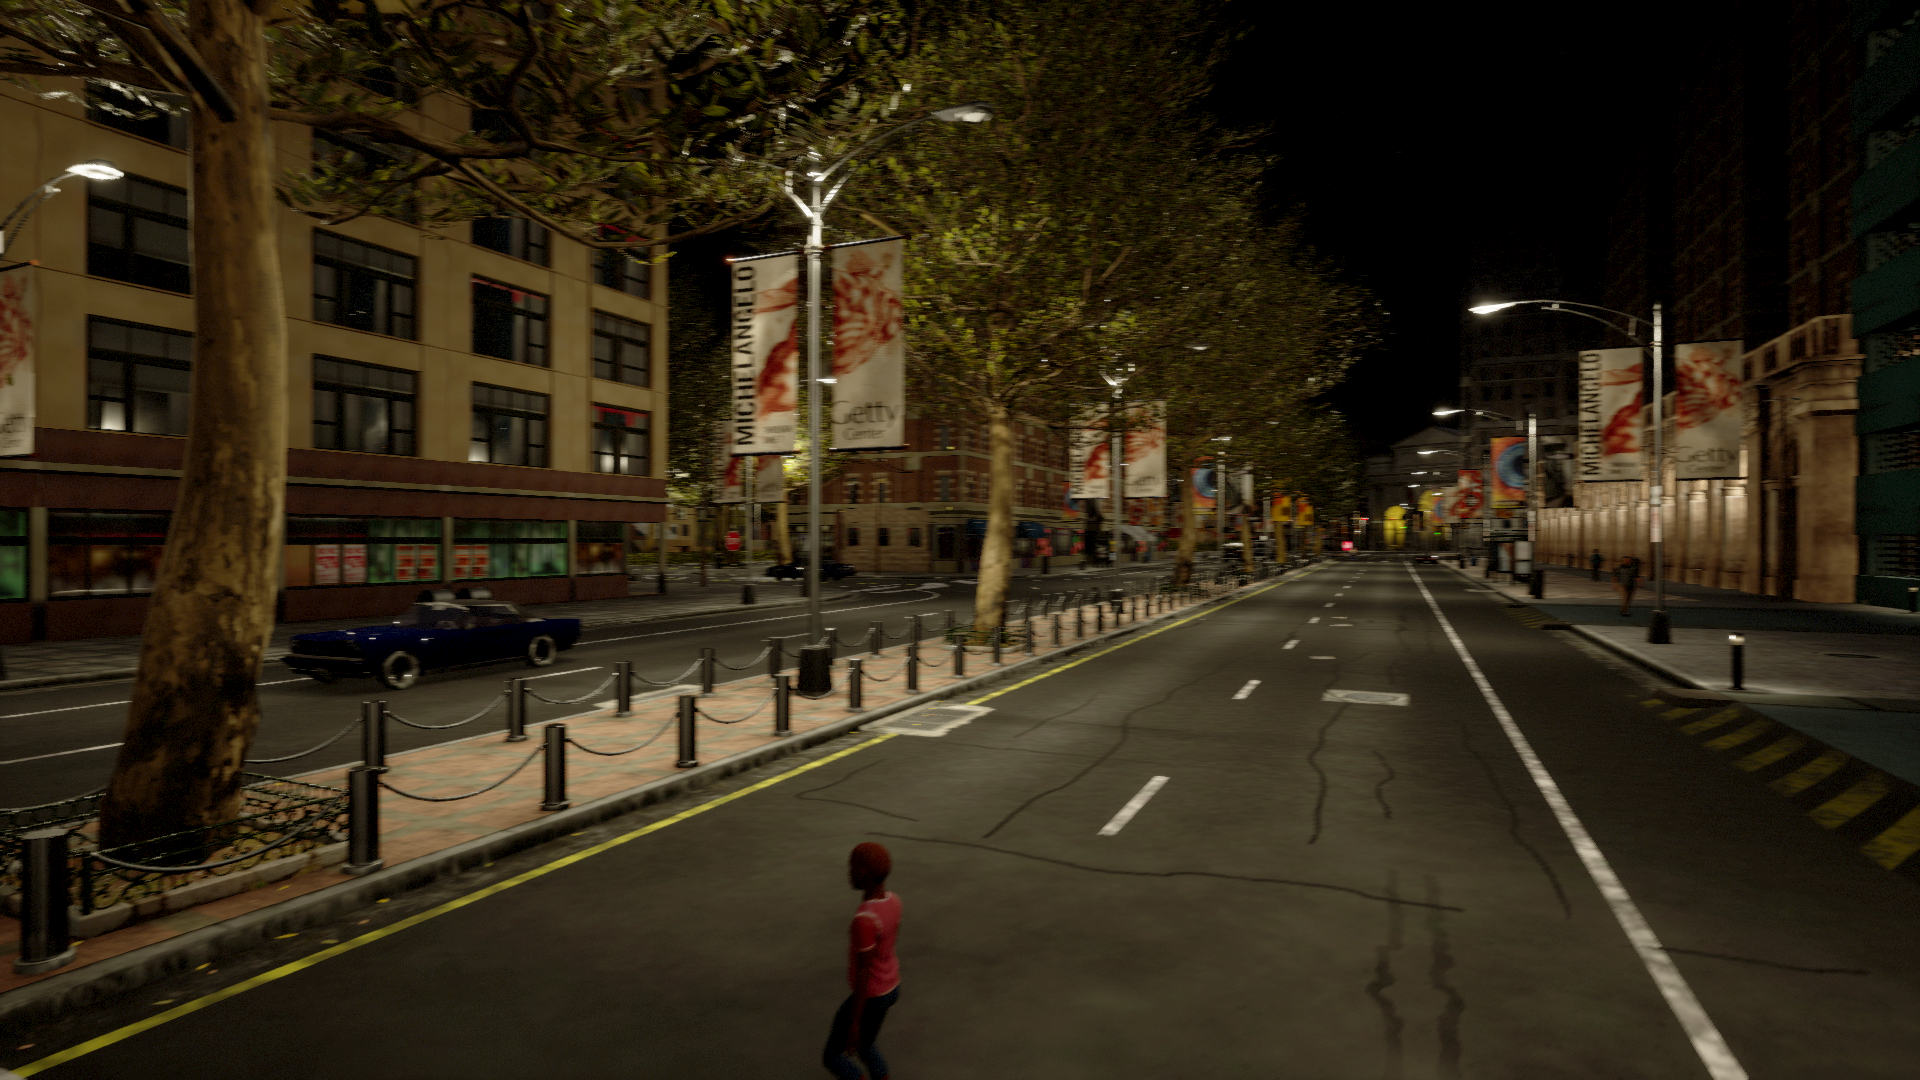

In [11]:
Image.open(os.path.join(root_dir, 'rgb', '11.png'))